In [1]:
%reset -sf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from flow import *
from utils import *
import get_data as gd
import gc

import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2023-11-18 15:36:20.883947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



### Load data

In [2]:
processor = gd.DataProcessor()
path = "/root/work/truth/signal/*npz"
processor.load_files(path)

(
    CGLMP,
    Higgs,
    LeadLep,
    LepM,
    LepP,
    NuM,
    NuP,
    MET,
    Wm,
    Wp,
    diLep,
    SubLep,
    Xi,
) = processor.files
GEV = 1E3

# observed (Y)
## leps
lep_kin = pd.concat([LepP.iloc[:, 0:4], LepM.iloc[:, 0:4]], axis=1)/GEV
## MET
MET_kin = MET.iloc[:, 1:3]/GEV
# y -> observed params
MET_kin = pd.concat([MET_kin, lep_kin], axis=1)
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(3))
print()

# interest (X)
# x -> interested unknowns
## neus
nu_kin = pd.concat([NuP.iloc[:, 0:4], NuM.iloc[:, 0:4]], axis=1)/GEV
dinu_kin = pd.concat([nu_kin, CGLMP], axis=1)
print("dinu_kin shape:", dinu_kin.shape)
print(dinu_kin.head(3))
print()

del processor  # Clear the instance
del (
    CGLMP,
    Higgs,
    LeadLep,
    LepM,
    LepP,
    NuM,
    NuP,
    MET,
    Wm,
    Wp,
    diLep,
    SubLep,
    Xi,
)  # Clear the dataframes
del lep_kin, nu_kin
gc.collect()

['/root/work/truth/signal/CGLMP.npz', '/root/work/truth/signal/Higgs.npz', '/root/work/truth/signal/LeadLepton.npz', '/root/work/truth/signal/LeptonM.npz', '/root/work/truth/signal/LeptonP.npz', '/root/work/truth/signal/LmNu.npz', '/root/work/truth/signal/LpNu.npz', '/root/work/truth/signal/MET.npz', '/root/work/truth/signal/WmBoson.npz', '/root/work/truth/signal/WpBoson.npz', '/root/work/truth/signal/diLepton.npz', '/root/work/truth/signal/subLeadLepton.npz', '/root/work/truth/signal/xi_xyz.npz']

MET_kin shape: (2928862, 10)
           px         py           E        px         py          pz  \
0   21.531590  58.661363   19.465703 -5.065763  16.360542   -9.250574   
1  142.831582 -36.235636  131.817141  8.901175   2.966260  131.482766   
2   -4.344014 -53.593527   94.193734 -3.040100  49.431305   80.123430   

           E         px         py         pz  
0  12.031222  11.081455   2.673936  -3.847299  
1  66.401992 -13.096559  14.755815  63.403242  
2  26.267500   7.589698   1.67

0

### Preprocessing

In [3]:
from sklearn.model_selection import train_test_split

# sampling
np.random.seed(42)  # set random seed
indices_arr = np.arange(dinu_kin.shape[0], dtype="int")
indices_arr = np.random.choice(indices_arr, int(1e4))

# normalize
from sklearn.preprocessing import StandardScaler

SCALAR_int = StandardScaler()
norm_var = SCALAR_int.fit_transform(dinu_kin.iloc[indices_arr])
dinu_kin = norm_var
print(f"mean: {dinu_kin.mean()}; std: {dinu_kin.std()}")

SCALAR_MET = StandardScaler()
norm_var = SCALAR_MET.fit_transform(MET_kin.iloc[indices_arr])
MET_kin = norm_var
print(f"mean: {MET_kin.mean()}; std: {MET_kin.std()}")

del norm_var

train_indices, test_indices = train_test_split(
    np.arange(len(indices_arr.flatten())), train_size=0.8, test_size=0.2, random_state=42
)

train_x = dinu_kin[train_indices]
test_x = dinu_kin[test_indices]
train_y = MET_kin[train_indices]
test_y = MET_kin[test_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

mean: 7.056981261980995e-18; std: 1.0
mean: 3.0464519795714294e-18; std: 0.9999999999999999
X (Interest)
Training data shape: (8000, 11);
Testing data shape: (2000, 11).
Y (Observed)
Training data shape: (8000, 10);
Testing data shape: (2000, 10).



### Setup

In [4]:
# interest (momentum)
x_dim = train_x.shape[1]
# observed (MET)
y_dim = train_y.shape[1]

# * hyperparameter
z_dim = 4 # we only take intrinsic dimension into account

tot_dim = y_dim + z_dim
pad_dim = tot_dim - x_dim

# Preprocess
## Pad data
X = train_x.reshape((-1, x_dim))
# print("pad_dim", pad_dim)
pad_x = np.zeros((X.shape[0], pad_dim))
print("pad_x", pad_x.shape)
# print("pad_x", pad_x.shape)
x = np.concatenate([X, pad_x], axis=-1).astype("float32")
print("x", x.shape)
z = np.random.multivariate_normal([0.0] * z_dim, np.eye(z_dim), X.shape[0]).astype(
    "float32"
)
y_hat = train_y.reshape(-1, y_dim)
print("y", y_hat.shape)
print("z", z.shape)
y = np.concatenate([z, y_hat], axis=-1).astype("float32")

print(f"Input dataset shape -> X:{x.shape}, Y: {y.shape}")

n_sample = X.shape[0]
print("n_sample", n_sample)
n_data = n_sample * train_y.shape[1]
print("n_data", n_data)
print()

# * hyperparameter
n_couple_layer = 5
n_hid_layer = 3
n_hid_dim = 512
learning_rate = 1e-4

# * hyperparameter
n_batch = 256
n_epoch = 64
n_display = n_batch

# Make dataset generator
x_data = tf.data.Dataset.from_tensor_slices(x)
y_data = tf.data.Dataset.from_tensor_slices(y)
dataset = (
    tf.data.Dataset.zip((x_data, y_data))
    .shuffle(buffer_size=X.shape[0])
    .batch(n_batch, drop_remainder=True)
    .repeat()
)

pad_x (8000, 3)
x (8000, 14)
y (8000, 10)
z (8000, 4)
Input dataset shape -> X:(8000, 14), Y: (8000, 14)
n_sample 8000
n_data 80000



2023-11-18 15:36:40.495270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46696 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-11-18 15:36:40.496672: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46696 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


### Initialize the model

In [5]:
model = NVP(tot_dim, n_couple_layer, n_hid_layer, n_hid_dim, name="NVP")
x = tfk.Input((tot_dim,))
model(x)
model.summary()

Model: "NVP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer0 (TwoNVPCouplingLaye  multiple                  1073194   
 rs)                                                             
                                                                 
 Layer1 (TwoNVPCouplingLaye  multiple                  1073194   
 rs)                                                             
                                                                 
 Layer2 (TwoNVPCouplingLaye  multiple                  1073194   
 rs)                                                             
                                                                 
Total params: 3219582 (12.28 MB)
Trainable params: 3219540 (12.28 MB)
Non-trainable params: 42 (336.00 Byte)
_________________________________________________________________


In [6]:
class Trainer(tfk.Model):
    def __init__(
        self,
        model,
        x_dim,
        y_dim,
        z_dim,
        tot_dim,
        n_couple_layer,
        n_hid_layer,
        n_hid_dim,
        shuffle_type="reverse",
    ):
        super(Trainer, self).__init__()
        self.model = model
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.tot_dim = tot_dim
        self.x_pad_dim = tot_dim - x_dim
        self.y_pad_dim = tot_dim - (y_dim + z_dim)
        self.n_couple_layer = n_couple_layer
        self.n_hid_layer = n_hid_layer
        self.n_hid_dim = n_hid_dim
        self.shuffle_type = shuffle_type

        self.w1 = 5.0
        self.w2 = 1.0
        self.w3 = 10.0
        self.loss_factor = 1.0
        self.loss_fit = MSE
        self.loss_latent = MMD_multiscale
        self.loss_backward = MMD_multiscale

    def train_step(self, data):
        x_data, y_data = data
        x = x_data[:, : self.x_dim]
        y = y_data[:, -self.y_dim :]
        z = y_data[:, : self.z_dim]
        y_short = tf.concat([z, y], axis=-1)

        # Forward loss
        with tf.GradientTape() as tape:
            y_out = self.model(x_data)
            pred_loss = self.w1 * self.loss_fit(
                y_data[:, self.z_dim :], y_out[:, self.z_dim :]
            )  # [zeros, y] <=> [zeros, yhat]
            output_block_grad = tf.concat(
                [y_out[:, : self.z_dim], y_out[:, -self.y_dim :]], axis=-1
            )  # take out [z, y] only (not zeros)
            latent_loss = self.w2 * self.loss_latent(
                y_short, output_block_grad
            )  # [z, y] <=> [zhat, yhat]
            forward_loss = pred_loss + latent_loss
        grads_forward = tape.gradient(forward_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_forward, self.model.trainable_weights))

        # Backward loss
        with tf.GradientTape() as tape:
            x_rev = self.model.inverse(y_data)
            # rev_loss = self.w3 * self.loss_factor * self.loss_fit(x_rev, x_data)
            rev_loss = self.w3 * self.loss_factor * self.loss_backward(x_rev, x_data)
        grads_backward = tape.gradient(rev_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(
            zip(grads_backward, self.model.trainable_weights)
        )

        total_loss = forward_loss + latent_loss + rev_loss
        return {
            "total_loss": total_loss,
            "forward_loss": forward_loss,
            "latent_loss": latent_loss,
            "rev_loss": rev_loss,
        }

    def test_step(self, data):
        x_data, y_data = data
        return NotImplementedError

In [7]:
trainer = Trainer(
    model, x_dim, y_dim, z_dim, tot_dim, n_couple_layer, n_hid_layer, n_hid_dim
)
trainer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

### Training

In [8]:
LossFactor = UpdateLossFactor(n_epoch)
logger = NBatchLogger(n_display, n_epoch)
hist = trainer.fit(
    dataset,
    batch_size=n_batch,
    epochs=n_epoch,
    steps_per_epoch=n_data // n_batch,
    callbacks=[logger, LossFactor],
    verbose=2,
)

=== Started at 2023-11-18 15h:36m:41s ===
Epoch 1/64


2023-11-18 15:36:49.813782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-18 15:36:49.831716: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efb08035950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-18 15:36:49.831839: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-18 15:36:49.831848: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-18 15:36:49.847413: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-18 15:36:50.268283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-18 15:36:50.48094

 2023-11-18 15h:37m:18s | Epoch: 01/64 | total_loss=3.169882 forward_loss=2.863883 latent_loss=0.042380 rev_loss=0.263619
312/312 - 36s - total_loss: 3.1699 - forward_loss: 2.8639 - latent_loss: 0.0424 - rev_loss: 0.2636 - 36s/epoch - 116ms/step
Epoch 2/64
312/312 - 15s - total_loss: 3.9220 - forward_loss: 3.6210 - latent_loss: 0.0386 - rev_loss: 0.2624 - 15s/epoch - 49ms/step
Epoch 3/64
312/312 - 19s - total_loss: 2.8668 - forward_loss: 2.5791 - latent_loss: 0.0357 - rev_loss: 0.2520 - 19s/epoch - 61ms/step
Epoch 4/64
312/312 - 22s - total_loss: 3.3625 - forward_loss: 3.0743 - latent_loss: 0.0333 - rev_loss: 0.2549 - 22s/epoch - 70ms/step
Epoch 5/64
312/312 - 19s - total_loss: 2.6172 - forward_loss: 2.3405 - latent_loss: 0.0345 - rev_loss: 0.2422 - 19s/epoch - 62ms/step
Epoch 6/64
312/312 - 20s - total_loss: 2.5228 - forward_loss: 2.2460 - latent_loss: 0.0338 - rev_loss: 0.2429 - 20s/epoch - 65ms/step
Epoch 7/64
312/312 - 20s - total_loss: 2.3162 - forward_loss: 2.0315 - latent_loss: 

KeyboardInterrupt: 

### Results

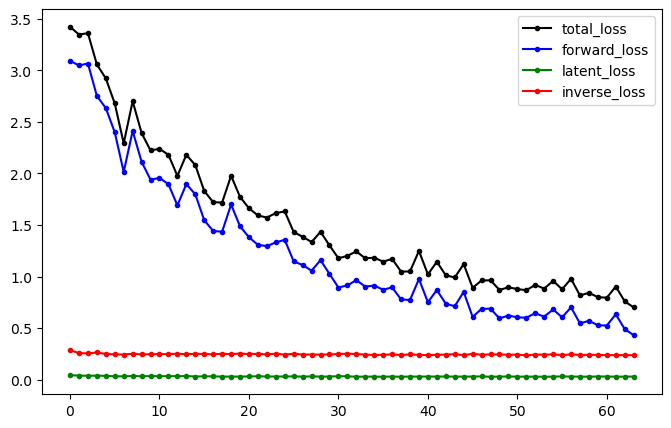

In [ ]:
fig, ax = plt.subplots(1, facecolor="white", figsize=(8, 5))
ax.plot(hist.history["total_loss"], "k.-", label="total_loss")
ax.plot(hist.history["forward_loss"], "b.-", label="forward_loss")
ax.plot(hist.history["latent_loss"], "g.-", label="latent_loss")
ax.plot(hist.history["rev_loss"], "r.-", label="inverse_loss")
plt.legend()
plt.savefig("loss.png")
plt.show()
plt.close()

In [ ]:
# Preprocess
z = np.random.multivariate_normal([1.0] * z_dim, np.eye(z_dim), test_y.shape[0])
y = np.concatenate([z, test_y], axis=-1).astype("float32")
x_pred = model.inverse(y).numpy()
print("x_pred", x_pred.shape)
pz_pred = x_pred[:, 3] + x_pred[:, 7]
pt_pred = np.sqrt(
    np.square(x_pred[:, 1] + x_pred[:, 5]) + np.square(x_pred[:, 2] + x_pred[:, 6])
)
E_pred = x_pred[:, 0] + x_pred[:, 4]

pz_truth = test_x[:, 3] + test_x[:, 7]
pt_truth = np.sqrt(
    np.square(test_x[:, 1] + test_x[:, 5]) + np.square(test_x[:, 2] + test_x[:, 6])
)
E_truth = test_x[:, 0] + test_x[:, 4]

x_pred (2000, 12)


pz -> Pearson coeff: 0.165
E  -> Pearson coeff: 0.046
pt -> Pearson coeff: 0.111


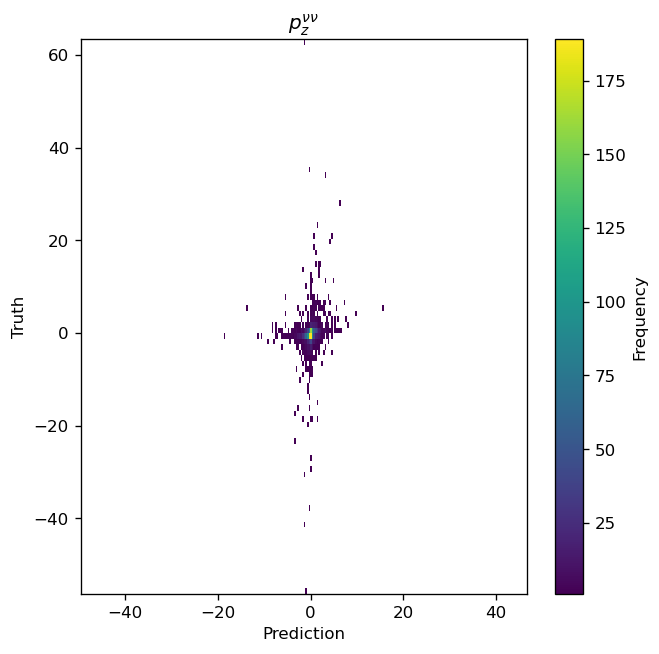

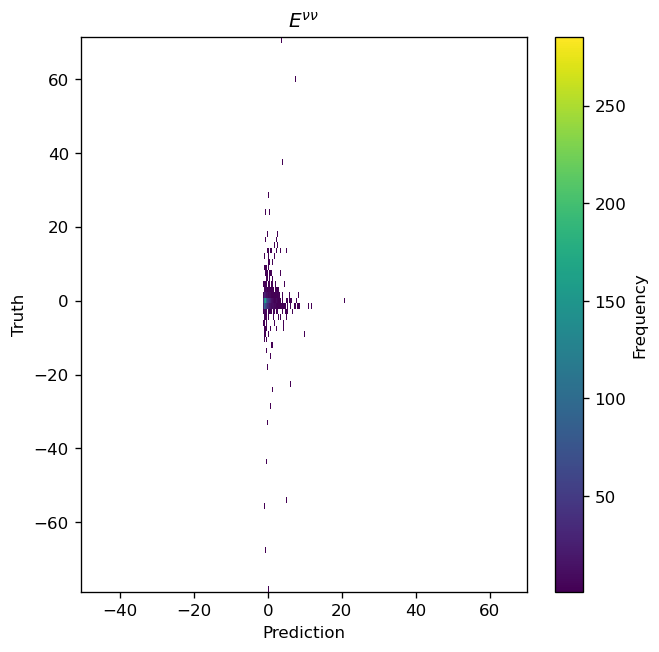

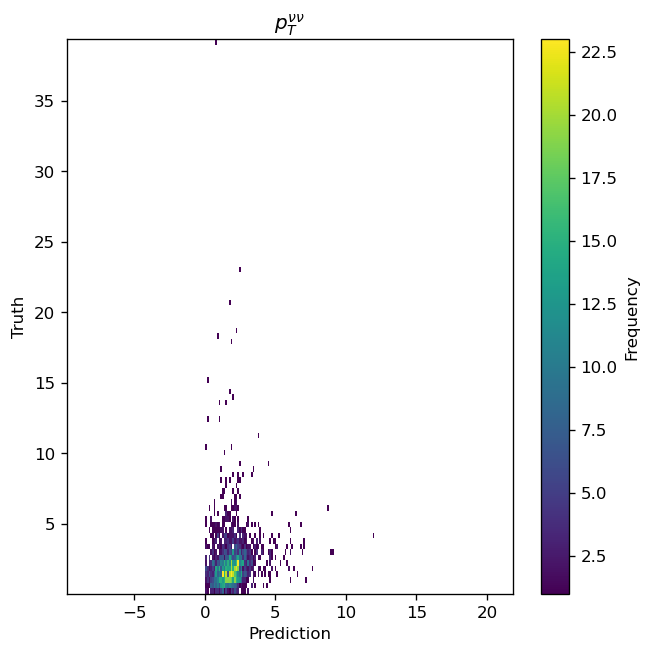

====================== Finished!! ======================


In [ ]:
def plot_2d_histogram(pred, truth, title, save_name, bins=100):
    hist, xedges, yedges = np.histogram2d(pred.flatten(), truth, bins=(bins, bins))
    hist = np.ma.masked_where(hist == 0, hist)
    fig = plt.figure(figsize=(6, 6), dpi=120)
    plt.pcolormesh(xedges, yedges, hist.T, cmap="viridis")
    cbar = plt.colorbar()
    cbar.set_label("Frequency")
    plt.title(title)
    plt.xlabel("Prediction")
    plt.ylabel("Truth")
    plt.savefig(save_name)
    plt.axis("equal")
    plt.show()
    plt.close()


# Plot the results
import scipy as sp

print(f"pz -> Pearson coeff: {sp.stats.pearsonr(pz_truth, pz_pred)[0]:.3f}")
print(f"E  -> Pearson coeff: {sp.stats.pearsonr(E_truth, E_pred)[0]:.3f}")
print(f"pt -> Pearson coeff: {sp.stats.pearsonr(pt_truth, pt_pred)[0]:.3f}")
plot_2d_histogram(pz_truth, pz_pred, r"$p^{\nu\nu}_{z}$", save_name="pz.png")
plot_2d_histogram(E_truth, E_pred, r"$E^{\nu\nu}$", save_name="energy.png")
plot_2d_histogram(pt_truth, pt_pred, r"$p^{\nu\nu}_{T}$", save_name="pt.png")

print("====================== Finished!! ======================")
